# Intro 

This repository aims to summarize a basic way to backprop through stochastic computation graph. In other words, how to backprop through sampled i.e., non-deterministic variables. There are two basic techniques

- score function a.k.a. REINFORCE algorithm
- pathwise derivative a.k.a. reparameterization trick

see also
- overview https://pytorch.org/docs/stable/distributions.html
- detail https://arxiv.org/pdf/1506.05254.pdf.


This notebook gives some score function estimator examples with chainer.

# 1. Score function method

Given a continuous parameterized probability function $p(\cdot ; \theta)$ (e.g., neural network), i.i.d. sampled actions $x \sim p(x; \theta)$ and score function $f(x)$. An expected score of the action is
\begin{align}
E_x[f(x)] &= \sum_x p(x; \theta) f(x)
\end{align}
And its gradient with respect to $\theta$ for learning better action probability (i.e., policy)
\begin{align}
\frac{\partial}{\partial x} E[f(x)] &= \frac{\partial}{\partial \theta} \sum_x p(x; \theta) f(x) \\
&= \sum_x p(x; \theta) \frac{\partial}{\partial \theta} \log p(x; \theta) f(x) \\
&= E\left[\frac{\partial}{\partial \theta} \log p(x; \theta) f(x) \right]
\end{align}

We use gradient of log function here to derive this equation. Note that the score function $f$ need not be differentiable w.r.t. $\theta$ because the gradient is the expected form now. We can approximate the gradients by Monte-Calro sampling.

### warning

While the score function is a criteria to be maximized, chainer needs a loss function to be minimized in `loss.backward`. We need to set `loss = - log_prob * score` before backprop.

Let's define new `StochasticChain` interface for stochastic computation graph for MC estimation. Here we only need `sample` and `log_prob` method in the equations above.

In [1]:
%matplotlib inline
from matplotlib import pyplot
pyplot.style.use("ggplot")

import chainer
import numpy
import chainer
import chainer.functions as F
import gym

In [2]:
class StochasticChain(chainer.Chain):
    """Stochastic chain interface in stochastic computation graph"""

    def sample(self, n: int) -> chainer.Variable:
        """returns n-sample chainer.Variable"""
        pass
    
    def log_prob(self, samples: chainer.Variable) -> chainer.Variable:
        """returns log probability of sampled chainer.Variable by self pdf/pmf"""
        pass

## 1.1 Stochastic chain implementation of basic distribution

Here, we define very basic distribution for discrete and real values

[0.2 0.3 0.5]


(array([0.202, 0.291, 0.507]),
 array([0, 1, 2, 3]),
 <a list of 3 Patch objects>)

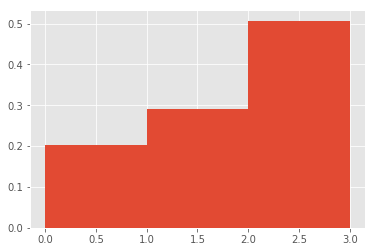

In [3]:
class Categorical(StochasticChain):
    def __init__(self, probs):
        super().__init__()
        self.n_class = len(probs)
        with self.init_scope():
            if isinstance(probs, chainer.Variable):
                self.probs = probs
            else:
                self.probs = chainer.Parameter(probs)
    
    def sample(self, n: int) -> chainer.Variable:
        s = self.xp.random.choice(self.n_class, size=n, p=self.probs.data).astype(numpy.int32)
        return chainer.Variable(s)

    def log_prob(self, samples: chainer.Variable) -> chainer.Variable:
        return self.probs.data[samples]
    
cat = Categorical(numpy.array([0.2, 0.3, 0.5], dtype=numpy.float32))
xs = cat.sample(1000)
print(cat.log_prob([0, 1, 2]))
pyplot.hist(xs.data, range(4), density=True)

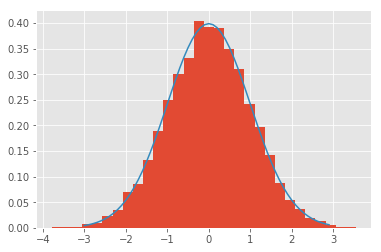

In [4]:
## NOTE: you can use this instead of scratch implementation in upcoming 5.0.0
# from chainer.distributions import MultivariateNormal

def unsqueeze(x: chainer.Variable, dim: int):
    if dim < 0:
        dim = x.ndim + 1 + dim
    s = x.shape[:dim] + (1,) + x.shape[dim:]
    return x.reshape(s)

LOG_2PI = numpy.log(2 * numpy.pi).astype(numpy.float32)

class MultivariateNormal(StochasticChain):
    
    def __init__(self, mean, scale_tril):
        assert mean.ndim == 1
        assert scale_tril.ndim == 2
        super().__init__()
        with self.init_scope():
            self.mean = chainer.Parameter(mean)
            self.scale_tril = chainer.Parameter(scale_tril)

    def sample(self, n: int) -> chainer.Variable:
        shape = (n,) + self.mean.shape + (1,)
        x = self.xp.random.normal(size=shape).astype(self.mean.dtype)
        scaled = F.matmul(self.scale_tril, x)
        return F.squeeze(scaled, -1) + self.mean
    
    def mahalanobis_distance(self, xs: chainer.Variable) -> chainer.Variable:
        diff = xs - self.mean  # (batch, ndim)
        iscale = F.inv(self.scale_tril.T)
        m = F.matmul(unsqueeze(diff, 1), unsqueeze(iscale, 0))
        m = F.matmul(m, F.swapaxes(m, -1, -2))
        return F.squeeze(m, (-1, -2))  # (batch,)

    def log_prob(self, xs: chainer.Variable) -> chainer.Variable:
        assert xs.ndim == 2
        assert xs.shape[1] == self.mean.shape[0]
        m = self.mahalanobis_distance(xs)
        log_det = F.log(F.det(self.scale_tril)) * 2
        ret = -0.5 * (m + self.mean.shape[-1] * LOG_2PI) - log_det
        return ret

# 1-D (univariate) normal distribution test
prob_fun = MultivariateNormal(numpy.array([0.0], dtype=numpy.float32),
                              scale_tril=numpy.array([[1.0]], dtype=numpy.float32))
xs = prob_fun.sample(10000)
prob_fun.log_prob(xs).shape
pyplot.hist(xs.data, bins=30, density=True)
r = numpy.arange(-3, 3, 0.1, dtype=numpy.float32)
pyplot.plot(r, F.exp(prob_fun.log_prob(unsqueeze(r, 1))).data)

## 1.2 Stochastic backprop via sampled variables

Let's consider practical examples using those basic distributions

### Categorical distribution MC estimation

- parameters: action probabilities $p_1, \dots, p_K$, number of action types $K$ (fixed)
- probability: mass function given by observation $o$ and parameterized by a neural network $p(x = k | o; p_1, \dots, p_K) = \mathrm{softmax}(\mathrm{nn}(o))$
- score: normalized discounted cartpole environment score

This is known as REINFORCE algorithm https://github.com/jankrepl/CartPole-v0_REINFORCE

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


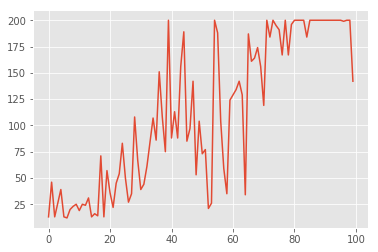

In [5]:
import chainer.links as L

class Policy(chainer.Chain):
    def __init__(self, n_input, n_output, n_units=32):
        super(Policy, self).__init__()
        with self.init_scope():
            self.affine1 = L.Linear(numpy.prod(n_input), n_units)
            self.action_head = L.Linear(n_units, n_output)

    def __call__(self, x):
        x = F.relu(self.affine1(x))
        return F.softmax(self.action_head(x))


def discount(rewards):
    R = 0
    discounted_rewards = []
    for r in rewards[::-1]:
        R = r + 0.99 * R
        discounted_rewards.insert(0, R)
    rewards = model.xp.array(discounted_rewards, dtype=numpy.float32)
    rewards = (rewards - rewards.mean()) / (rewards.std() + numpy.finfo(numpy.float32).eps)
    rewards = chainer.Variable(rewards).reshape(1, -1)
    return rewards


env = gym.make('CartPole-v0')
model = Policy(n_input=env.observation_space.shape,
               n_output=env.action_space.n)
optimizer = chainer.optimizers.Adam(alpha=0.01)
optimizer.setup(model)
history = []
for episode in range(100):
    observation = env.reset()
    probs = []
    rewards = []
    sum_rewards = 0
    done = False
    while not done:
        state = observation.astype(numpy.float32).reshape(1, *observation.shape)
        ps = model(chainer.Variable(model.xp.array(state)))
        action = Categorical(ps[0]).sample(1).data[0]
        p = ps[:, action]
        observation, reward, done, info = env.step(action)
        probs.append(p)
        rewards.append(reward)
        sum_rewards += reward

    rewards = discount(rewards)
    log_probs = F.log(F.concat(probs, axis=0))
    loss = -F.sum(rewards * log_probs)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    history.append(sum_rewards)
    
# NOTE: 200 is the max reward
pyplot.plot(history)

## Gaussian distribution MC estimation

- parameters: mean $\mu$, variance $L$
- probability: density function $p(x; \mu, L) = \frac{1}{\sqrt{2 \pi |L L^\top|}} \exp \left\{\left(x - \mu\right) \left(L L^\top\right)^{-1} \left(x - \mu\right)^\top \right\} $
- score: N sample negative KL divergence between reference and hypothesis distributions $f(x) = -\frac{1}{N} \sum_{n=0}^{N} p(x_n; \mu, L) \log \frac{p(x_n; \mu, L)}{p(x_n; \mu_\mathrm{ref}, L_\mathrm{ref})}$

reference mean=-1.000000, scale=2.000000
estimated mean=-0.968082, scale=1.963374


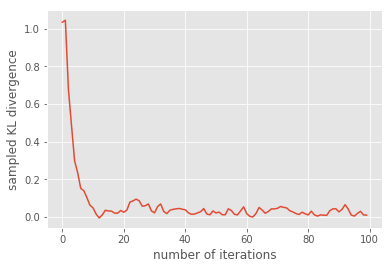

In [6]:
# Gaussian fitting example
hyp = MultivariateNormal(numpy.array([0.0], dtype=numpy.float32),
                         scale_tril=numpy.array([[1.0]], dtype=numpy.float32))
ref = MultivariateNormal(numpy.array([-1.0], dtype=numpy.float32),
                         scale_tril=numpy.array([[2.0]], dtype=numpy.float32))

optim = chainer.optimizers.SGD(lr=0.1)
optim.setup(hyp)
history = []
for i in range(100):
    with chainer.no_backprop_mode():
        xs = hyp.sample(10000)
        rlogp = ref.log_prob(xs)
    logp = hyp.log_prob(xs)
    sampled_kl = (rlogp - logp) * logp
    expected_loss = F.mean(logp * sampled_kl)
    hyp.cleargrads()
    expected_loss.backward()
    optim.update()
    history.append(-float(expected_loss.data))

pyplot.plot(history)
pyplot.ylabel("sampled KL divergence")
pyplot.xlabel("number of iterations")
print("reference mean={:.6f}, scale={:.6f}".format(ref.mean[0].data, ref.scale_tril.data[0, 0]))
print("estimated mean={:.6f}, scale={:.6f}".format(hyp.mean[0].data, hyp.scale_tril.data[0, 0]))